In [61]:
##PDF SCRAPING LIBRARIES

from langchain_community.document_loaders import PDFMinerLoader,PyPDFLoader,PDFMinerPDFasHTMLLoader
import re
from langchain_community.docstore.document import Document


#PDF SCRAPING

##PyPDFLoader###
def scrape_pdf_PyPDF(url):
    

    loader = PyPDFLoader(url,extract_images=True)
    pages = loader.load_and_split()

    return pages




##PDFMinerLoader###
def scrape_pdf_PDFMiner(url):
    

    loader = PDFMinerPDFasHTMLLoader(url)
    data = loader.load()[0]
    
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(data.page_content,'html.parser')
    content = soup.find_all('div')
    
    
    cur_fs = None
    cur_text = ''
    snippets = []   # first collect all snippets that have the same font size
    for c in content:
        sp = c.find('span')
        if not sp:
            continue
        st = sp.get('style')
        if not st:
            continue
        fs = re.findall('font-size:(\d+)px',st)
        if not fs:
            continue
        fs = int(fs[0])
        if not cur_fs:
            cur_fs = fs
        if fs == cur_fs:
            cur_text += c.text
        else:
            snippets.append((cur_text,cur_fs))
            cur_fs = fs
            cur_text = c.text
    snippets.append((cur_text,cur_fs))



    print(snippets)


    cur_idx = -1
    semantic_snippets = []
    # Assumption: headings have higher font size than their respective content
    for s in snippets:
        # if current snippet's font size > previous section's heading => it is a new heading
        if not semantic_snippets or s[1] > semantic_snippets[cur_idx].metadata['heading_font']:
            metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
            metadata.update(data.metadata)
            semantic_snippets.append(Document(page_content='',metadata=metadata))
            cur_idx += 1
            continue

        # if current snippet's font size <= previous section's content => content belongs to the same section (one can also create
        # a tree like structure for sub sections if needed but that may require some more thinking and may be data specific)
        if not semantic_snippets[cur_idx].metadata['content_font'] or s[1] <= semantic_snippets[cur_idx].metadata['content_font']:
            semantic_snippets[cur_idx].page_content += s[0]
            semantic_snippets[cur_idx].metadata['content_font'] = max(s[1], semantic_snippets[cur_idx].metadata['content_font'])
            continue

        # if current snippet's font size > previous section's content but less than previous section's heading than also make a new
        # section (e.g. title of a PDF will have the highest font size but we don't want it to subsume all sections)
        metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
        metadata.update(data.metadata)
        semantic_snippets.append(Document(page_content='',metadata=metadata))
        cur_idx += 1


    return semantic_snippets


In [62]:
url='./PDF_FOLDER/adaptive_pooling.pdf'
#url="./PDF_FOLDER/shannon_51.pdf"

In [19]:
results1=scrape_pdf_PyPDF(url)

In [20]:
results1[7]

Document(page_content='2\n1\n2\n16\n58\n19\n5\n1\n4\n3\n2\n1\n1\n1\n1\n1\n1\n1\n1\n7\n48\n17\n3\n4\n3\n2\n8\n2\n4\n3\n1\n1\n1\n1\n1\n18\n66\n15\n5\n4\n6\n1\n1\n1\n1\n»\n66\n13\n9\n4\n1\n1\n1\n2\n1\n1\n110\n67\n10\n4\n4\n6\n1\n1\n1\n1\n3\n1\n1\nu\n62\n9\n7\n5\n5\n4\n1\n1\n1\n2\n1\n1\n112\n58\n14\n7\n6\n2\n2\n4\n2\n1\n1\n1\n1\n113\n66\n9\n4\n4\n3\n3\n1\n2\n2\n1\n1\n1\n1\n214\n72\n6\n9\n3\n4\n1\n1\n2\n215\n60\n18\n5\n5\n1\n4\n3\n1\n1\n1\n1100\n80\n7\n3\n4\n2\n1\n1\n1\n1\nthe entry 19 in column 6, row 2, means that with five letters known thi cor\nrect letter was obtained on the second guess nineteen times out of the hun\ndred. The first two columns of this table were not obtained by the experi-\nmental procedure outlined above but were calculated directly from the\nknown letter and digram frequencies. Thus with no known letters the most\nprobable symbol is the space (probability .182); the next guess, if this is\nwrong, should be E (probability .107), etc. These probabilities are the\nfre

In [63]:
result=scrape_pdf_PDFMiner(url)

[('Adaptive Pooling Is All You Need: An Empirical\nStudy on Hyperparameter-insensitive Human Action\nRecognition Using Wearable Sensors\n', 23), ('Mubarak G. Abdu-Aguye\nDepartment of Computer Engineering\nAhmadu Bello University\nZaria, Nigeria\nmubarak.abduaguye@ejust.edu.eg\nWalid Gomaa\nComputer Science and Engineering\nEgypt-Japan University of Science and Technology\nNew Borg el-Arab, Egypt\nwalid.gomaa@ejust.edu.eg\nYasushi Makihara\nISIR\nOsaka University\nOsaka, Japan\nmakihara@am.sanken.osaka-u.ac.jp\nYasushi Yagi\nISIR\nOsaka University\nOsaka, Japan\nyagi@am.sanken.osaka-u.ac.jp\n', 10), ('Abstract—A plethora of techniques have been proposed in\nhuman action recognition ﬁelds, and particularly deep learning-\nbased methods such as convolutional neural networks (CNNs)\nhave achieved impressive results. Usually, there is need to tune\nhyper-parameters in the deep neural network (e.g., ﬁlter size,\nto achieve reasonable results. Such hyper-parameter\nstride)\ntuning is, howeve

In [67]:
result[0].page_content

"Mubarak G. Abdu-Aguye\nDepartment of Computer Engineering\nAhmadu Bello University\nZaria, Nigeria\nmubarak.abduaguye@ejust.edu.eg\nWalid Gomaa\nComputer Science and Engineering\nEgypt-Japan University of Science and Technology\nNew Borg el-Arab, Egypt\nwalid.gomaa@ejust.edu.eg\nYasushi Makihara\nISIR\nOsaka University\nOsaka, Japan\nmakihara@am.sanken.osaka-u.ac.jp\nYasushi Yagi\nISIR\nOsaka University\nOsaka, Japan\nyagi@am.sanken.osaka-u.ac.jp\nAbstract—A plethora of techniques have been proposed in\nhuman action recognition ﬁelds, and particularly deep learning-\nbased methods such as convolutional neural networks (CNNs)\nhave achieved impressive results. Usually, there is need to tune\nhyper-parameters in the deep neural network (e.g., ﬁlter size,\nto achieve reasonable results. Such hyper-parameter\nstride)\ntuning is, however, extremely time and resource-intensive even\nfor small models. In this paper, we posit that the inclusion of\nan adaptive pooling in CNNs used for human a

In [68]:
import camelot

In [69]:
tables = camelot.read_pdf(url)

In [70]:
tables

<TableList n=0>

In [75]:
import pdfquery
import pandas as pd

In [76]:
pdf = pdfquery.PDFQuery(url)
pdf.load()
pdf.tree.write('pdfXML.txt', pretty_print = True)

In [74]:
data

[                                  Abstract—A plethora             of  \
 0   human action recognition fields, and particula...            NaN   
 1                               based methods such as  convolutional   
 2                            have achieved impressive       results.   
 3                  performancehyper-parameters in the           deep   
 4                       stride) to achieve reasonable            NaN   
 5                       tuning is, however, extremely            NaN   
 6                           for small models. In this         paper,   
 7   an adaptive pooling in CNNs used for human act...            NaN   
 8                         largely eliminates the need            NaN   
 9                           ofically, we demonstrated            our   
 10  using inertial sensor data (i.e., a temporal s...            NaN   
 11  dimensional adaptive pooling. We compared the ...            NaN   
 12                          to conventional CNNs w

In [98]:
import tabula as tb
import pandas as pd
import re

In [123]:
file = url
data = tb.read_pdf(file, area = (331.1700134277344,
     375.5350036621094,
     541.0540161132812,
     439.4949951171875), pages = '3')

In [124]:
data

[                                    eterName Unnamed: 0
 0  1 Size\r2 Size\rStride\rol Size\rl Stride   2,3\r2,3]

In [119]:
import pymupdf4llm
output = pymupdf4llm.to_markdown(url, page_chunks=True ,write_images=True)

In [120]:
output

[{'metadata': {'format': 'PDF 1.5',
   'title': '',
   'author': '',
   'subject': '',
   'keywords': '',
   'creator': "'Certified by IEEE PDFeXpress at 04/04/2020 6:15:10 AM'",
   'producer': 'pdfTeX-1.40.19',
   'creationDate': 'D:20200404131156Z',
   'modDate': "D:20200404061510-07'00'",
   'trapped': '',
   'encryption': None,
   'file_path': './PDF_FOLDER/adaptive_pooling.pdf',
   'page_count': 6,
   'page': 1},
  'toc_items': [],
  'tables': [],
  'images': [],
  'graphics': [],
  'text': '# Adaptive Pooling Is All You Need: An Empirical Study on Hyperparameter-insensitive Human Action Recognition Using Wearable Sensors\n\n\nMubarak G. Abdu-Aguye\n_Department of Computer Engineering_\n_Ahmadu Bello University_\nZaria, Nigeria\nmubarak.abduaguye@ejust.edu.eg\n\n\nWalid Gomaa\n_Computer Science and Engineering_\n_Egypt-Japan University of Science and Technology_\nNew Borg el-Arab, Egypt\nwalid.gomaa@ejust.edu.eg\n\n\nYasushi Makihara\n_ISIR_\n_Osaka University_\nOsaka, Japan\nmaki

In [117]:
import pymupdf4llm
llama_reader = pymupdf4llm.LlamaMarkdownReader()
llama_docs = llama_reader.load_data(url)

Successfully imported LlamaIndex


In [118]:
llama_docs

[Document(id_='fd20e710-8407-40f4-adcb-8d6b6b2f5d24', embedding=None, metadata={'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': "'Certified by IEEE PDFeXpress at 04/04/2020 6:15:10 AM'", 'producer': 'pdfTeX-1.40.19', 'creationDate': 'D:20200404131156Z', 'modDate': "D:20200404061510-07'00'", 'trapped': '', 'encryption': None, 'page': 1, 'total_pages': 6, 'file_path': './PDF_FOLDER/adaptive_pooling.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='# Adaptive Pooling Is All You Need: An Empirical Study on Hyperparameter-insensitive Human Action Recognition Using Wearable Sensors\n\n\nMubarak G. Abdu-Aguye\n_Department of Computer Engineering_\n_Ahmadu Bello University_\nZaria, Nigeria\nmubarak.abduaguye@ejust.edu.eg\n\n\nWalid Gomaa\n_Computer Science and Engineering_\n_Egypt-Japan University of Science and Technology_\nNew Borg el-Arab, Egypt\nwalid.gomaa@ejust.edu.eg\n\n\nYasushi Makihara\n_ISIR_\n_Os

In [127]:
import pymupdf # imports the pymupdf library
doc = pymupdf.open(url) # open a document
for page in doc: # iterate the document pages
    text = page.get_table()

AttributeError: 'Page' object has no attribute 'get_table'

In [126]:
text

"[11] O. Banos, M. Damas, H. Pomares, I. Rojas, M. A. Toth, and\nO. Amft, “A benchmark dataset to evaluate sensor displacement\nin\nactivity\nrecognition,”\nin\nProceedings\nof\nthe\n2012\nACM\nConference on Ubiquitous Computing, ser. UbiComp ’12.\nNew\nYork, NY, USA: ACM, 2012, pp. 1026–1035. [Online]. Available:\nhttp://doi.acm.org/10.1145/2370216.2370437\n[12] O. Banos, M. A. Toth, M. Damas, H. Pomares, and I. Rojas,\n“Dealing with the effects of sensor displacement in wearable activity\nrecognition,” Sensors, vol. 14, no. 6, pp. 9995–10 023, 2014. [Online].\nAvailable: http://www.mdpi.com/1424-8220/14/6/9995\n[13] M. G. Abdu-Aguye and W. Gomaa, “Competitive feature extraction for\nactivity recognition based on wavelet transforms and adaptive pooling,”\nin 2019 International Joint Conference on Neural Networks (IJCNN),\nJuly 2019, pp. 1–8.\n[14] M. G. Abdu-Aguye and W. Gomaa, “Versatl: versatile transfer learning\nfor imu-based activity recognition using convolutional neural network

In [5]:
url='./PDF_FOLDER/adaptive_pooling.pdf'
#url="./PDF_FOLDER/shannon_51.pdf"

In [6]:
import pymupdf # imports the pymupdf library
import pandas

"""
Utility function for showing images.

Intended to be imported in Jupyter notebooks to display pixmap images.

Invocation: "show_image(item, title)", where item is a PyMuPDF object
which has a "get_pixmap" method, and title is an optional string.

The function executes "item.get_pixmap(dpi=150)" and show the resulting
image.


Dependencies
------------
numpy, matplotlib, pymupdf
"""


def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

In [7]:
import fitz  # import PyMuPDF
if not hasattr(fitz.Page, "find_tables"):
    raise RuntimeError("This PyMuPDF version does not support the table feature")

In [8]:
doc = fitz.open(url)
page = doc[2]

Table 0 column names: ['Hyperparameter Name', 'Values'], external: False


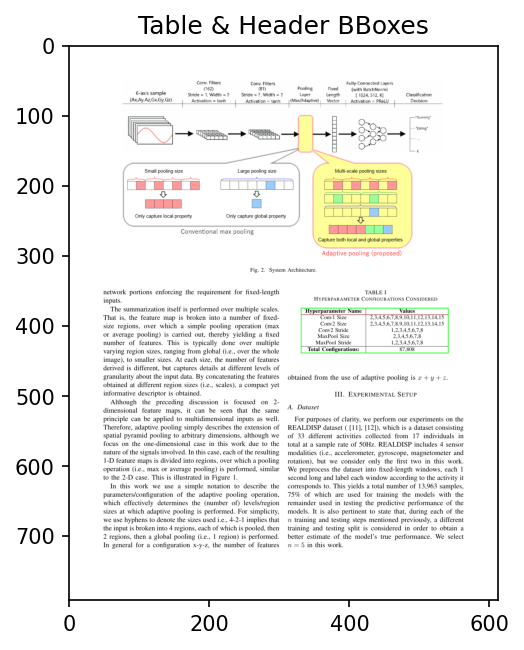

In [9]:
tabs = page.find_tables()  # detect the tables
for i,tab in enumerate(tabs):  # iterate over all tables
    for cell in tab.header.cells:
        page.draw_rect(cell,color=fitz.pdfcolor["red"],width=0.3)
    page.draw_rect(tab.bbox,color=fitz.pdfcolor["green"])
    print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")
    
show_image(page, f"Table & Header BBoxes")

In [10]:
# choose the second table for conversion to a DataFrame
tab = tabs[0]
df = tab.to_pandas()

# show the DataFrame
df

,Hyperparameter Name,Values
0,Conv1 Size\nConv2 Size\nConv2 Stride\nMaxPool ...,"2,3,4,5,6,7,8,9,10,11,12,13,14,15\n2,3,4,5,6,7..."
1,Total Configurations:,"87,808"
